In [16]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import process_time

In [2]:
#Data is from December 2017, zones 20 and 19
#Omiting 18 for now
AIS_raw_20 = pd.read_csv('AIS_2017_12_Zone20.csv', header=0)
AIS_raw_19 = pd.read_csv('AIS_2017_12_Zone19.csv', header=0)
#AIS_raw_18 = pd.read_csv('AIS_2017_12_Zone18.csv', header=0)

In [5]:
print("Number of rows of raw data: ", len(AIS_raw_19)+len(AIS_raw_20))
AIS_raw_20.head(5)

Number of rows of raw data:  6458339


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,311109000,2017-12-01T00:03:29,18.85018,-65.84870,18.2,130.9,129.0,NORWEGIAN SUN,IMO9218131,C6RN3,1012.0,under way using engine,258.59,32.25,NaN,NaN
1,671966000,2017-12-01T19:36:04,18.33037,-64.96089,0.0,-149.5,511.0,NaN,NaN,NaN,NaN,power-driven vessel towing astern,NaN,NaN,NaN,NaN
2,367573630,2017-12-01T00:03:10,18.28271,-65.63716,0.0,-123.3,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,232012229,2017-12-01T00:05:54,17.80085,-65.31860,6.9,37.7,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,366744150,2017-12-01T19:41:44,18.33495,-64.92114,0.0,-49.6,511.0,KON TIKI II,NaN,WDF6312,1012.0,under way using engine,27.43,10.00,NaN,NaN


In [6]:
#Seems to be quite a bit of NaN values, lets see how many for each column (by percentage)
print("Zone 20 NaN values: \n", AIS_raw_20.isna().sum()/(AIS_raw_20.count()+AIS_raw_20.isna().sum()))
print("Zone 19 NaN values: \n", AIS_raw_19.isna().sum()/(AIS_raw_19.count()+AIS_raw_19.isna().sum()))

Zone 20 NaN values: 
 MMSI            0.000000
BaseDateTime    0.000000
LAT             0.000000
LON             0.000000
SOG             0.000000
COG             0.000000
Heading         0.000000
VesselName      0.085074
IMO             0.388254
CallSign        0.109285
VesselType      0.162462
Status          0.285204
Length          0.262942
Width           0.357343
Draft           0.716716
Cargo           0.656410
dtype: float64
Zone 19 NaN values: 
 MMSI            0.000000
BaseDateTime    0.000000
LAT             0.000000
LON             0.000000
SOG             0.000000
COG             0.000000
Heading         0.000000
VesselName      0.049593
IMO             0.359425
CallSign        0.111849
VesselType      0.081110
Status          0.195460
Length          0.110947
Width           0.214627
Draft           0.723913
Cargo           0.637464
dtype: float64


In [7]:
#The good news is that all of the LAT and LON are available. An issue is that "status" has a decent number of NaNs
#How many ship IDs are there for each set
print("Number of ships zone 20: ", len(AIS_raw_20["MMSI"].unique()))
print("Number of ships zone 19: ", len(AIS_raw_19["MMSI"].unique()))

Number of ships zone 20:  969
Number of ships zone 19:  2286


In [8]:
#How many of these ships cross to the other zone during this time period
unique_20 = AIS_raw_20["MMSI"].unique().tolist()
unique_19 = AIS_raw_19["MMSI"].unique().tolist()

zonetozone2019 = set(unique_20) & set(unique_19)
print("Common ships from zone 20 to 19: ", len(zonetozone2019))

Common ships from zone 20 to 19:  550


In [10]:
#Combine zone 20 and 19, fill the NaN and observe the "status" breakdown of all of the ships
zone_20_19 = pd.concat([AIS_raw_20, AIS_raw_19])
zone_20_191 = zone_20_19.fillna('undefined')
status = zone_20_191.groupby(['Status']).agg(['count'])['MMSI']
print(status)

                                                      count
Status                                                     
AIS-SART (active); MOB-AIS; EPIRB-AIS                     1
at anchor                                             96350
constrained by her draught                            45411
engaged in fishing                                    33121
moored                                               515001
not under command                                     12669
power-driven vessel pushing ahead or towing alo...    23630
power-driven vessel towing astern                     14433
reserved for future use (10)                              6
reserved for future use (13)                              1
reserved for future use (9)                           11942
restricted maneuverability                            66729
undefined                                           2088158
under way sailing                                     12015
under way using engine                  

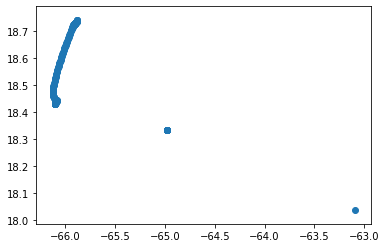

In [12]:
#Compiling 10 different ships that appear in both zone 20 and 19 and plot the locations in whihc they are 'moored'
ships_10_z2019 = zone_20_19[zone_20_19['MMSI'].isin(list(zonetozone2019)[:10])][['MMSI','LAT','LON','Status']]
plt.scatter(ships_10_z2019[ships_10_z2019['Status']=='moored']['LON'],ships_10_z2019[ships_10_z2019['Status']=='moored']['LAT'])


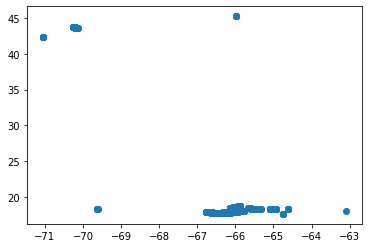

In [13]:
#Above shows 3 different mooring locations. For the most part, they are very localized. The long line is the 
#main puerto rico port, so a ship can technically be "moored" a bit outside the port
ships_10_z2019 = zone_20_19[zone_20_19['MMSI'].isin(list(zonetozone2019)[:40])][['MMSI','LAT','LON','Status']]
plt.scatter(ships_10_z2019[ships_10_z2019['Status']=='moored']['LON'],ships_10_z2019[ships_10_z2019['Status']=='moored']['LAT'])


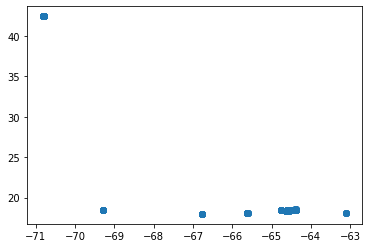

In [15]:
# This graph above looks promising. Localized areas we can define as Ports.
# Lets see if the other status' apply 'at anchor'
ships_10_z2019 = zone_20_19[zone_20_19['MMSI'].isin(list(zonetozone2019)[:40])][['MMSI','LAT','LON','Status']]
plt.scatter(ships_10_z2019[ships_10_z2019['Status']=='at anchor']['LON'],ships_10_z2019[ships_10_z2019['Status']=='at anchor']['LAT'])

In [17]:
#It seems the data is suitable for creating a graph of ships entering ports (nodes)
#Step by step process to create usable data for optimization (will time to gauge performance)

In [18]:
#Load data

t0_start = process_time() 

AIS_raw_20 = pd.read_csv('AIS_2017_12_Zone20.csv', header=0)
AIS_raw_19 = pd.read_csv('AIS_2017_12_Zone19.csv', header=0)

t0_end = process_time()

print("Load Time: ", t0_end-t0_start)
print("Number of rows: ", len(AIS_raw_20)+len(AIS_raw_19))

Load Time:  25.03125
Number of rows:  6458339


In [19]:
#Merge zones, keep necessary columns, remove NaN rows in 'Status' and keep only relevent statuses

t1_start = process_time() 

zones_comb_na = pd.concat([AIS_raw_20, AIS_raw_19])[["MMSI", "BaseDateTime", "LAT", "LON", "Status"]].dropna(subset=['Status']).reset_index(drop=True)
zones_comb = zones_comb_na[zones_comb_na['Status'].isin({'at anchor', 'constrained by her draught', 'engaged in fishing',\
                                                   'moored', 'power-driven vessel pushing ahead or towing alongside', \
                                                    'power-driven vessel towing astern', 'restricted maneuverability',\
                                                  'under way using engine'})]
t1_end = process_time()

print("Combine Time: ", t1_end-t1_start)
print("Number of rows: ", len(zones_comb_na))
zones_comb

Combine Time:  8.53125
Number of rows:  5150038


,MMSI,BaseDateTime,LAT,LON,Status
0,311109000,2017-12-01T00:03:29,18.85018,-65.84870,under way using engine
1,671966000,2017-12-01T19:36:04,18.33037,-64.96089,power-driven vessel towing astern
2,366744150,2017-12-01T19:41:44,18.33495,-64.92114,under way using engine
3,367617230,2017-12-01T00:12:44,18.29556,-65.39324,under way using engine
4,367617230,2017-12-01T00:13:52,18.29537,-65.38942,under way using engine
...,...,...,...,...,...
5150033,366953940,2017-12-31T23:53:24,44.11215,-69.10154,under way using engine
5150034,367912000,2017-12-31T23:53:26,41.52191,-70.66699,under way using engine
5150035,366953940,2017-12-31T23:54:33,44.11216,-69.10154,under way using engine
5150036,366953940,2017-12-31T23:56:45,44.11216,-69.10154,under way using engine


In [20]:
#Many of the ships do not change "status" (either stay moored or are only 'underway')
#Need to clean the data where the ship does not change status. 

t2_start = process_time() 

zones_comb_status = zones_comb.groupby("MMSI")['Status'].apply(set).reset_index()

for index,row in zones_comb_status.iterrows():
    if len(row['Status']) < 2:
        zones_comb_status.drop(index, inplace=True) 


t2_end = process_time()

print("Combine Time: ", t2_end-t2_start)
print("Number of rows: ", len(zones_comb_status))
zones_comb_status

Combine Time:  3.53125
Number of rows:  510


,MMSI,Status
3,205686000,"{under way using engine, at anchor}"
6,209141000,"{under way using engine, at anchor, moored}"
8,209263000,"{under way using engine, moored}"
11,209534000,"{under way using engine, moored}"
14,210057000,"{under way using engine, moored}"
...,...,...
1705,636092598,"{under way using engine, at anchor, moored}"
1707,636092684,"{under way using engine, moored}"
1710,671051000,"{under way using engine, moored}"
1711,671932000,"{under way using engine, moored}"


In [21]:
#Note the ships with useful informatio in the table above
useful_ships = zones_comb_status['MMSI'].unique().tolist()
zones_useful = zones_comb[zones_comb['MMSI'].isin(useful_ships)]
len(zones_useful)

1425459

In [57]:
# So far we went from 6.5 million to 1.5 million rows. Pretty good reduction in data. 
# The next step is to reduce the data further to where we have the ships when it enters a port and when it leave a port
# This means to track the status chronologically and note when there is a change. 

t3_start = process_time() 

zones_ordered = zones_useful.sort_values(['MMSI','BaseDateTime'],ascending=True)
zones_comb_list = zones_ordered.groupby("MMSI").agg({'Status':list, 'LAT':list, 'LON':list, 'BaseDateTime':list}).reset_index()

def compress_stat(row):
    stat = row['Status']
    time = row['BaseDateTime']
    lon = row['LON']
    lat = row['LAT']
    return [(stat[i+1],time[i+1],lon[i+1],lat[i+1]) for i,j,k in zip(np.arange(len(stat)-1), stat[:-1], stat[1:]) if (j!=k or i==0)]

zones_comb_list['Status_comp'] = zones_comb_list.apply(lambda row: compress_stat(row), axis=1)
zones_compressed = zones_comb_list.drop(['Status','LAT','LON','BaseDateTime'], axis=1)

# In case we want this as a dictionary
zones_compressed_dict = dict(zip(zones_compressed['MMSI'],zones_compressed['Status_comp']))

t3_end = process_time()

print("Combine Time: ", t3_end-t3_start)
print("Number of total datapoints: ", sum([len(i) for i in zones_compressed_dict.values()]))
zones_compressed


Combine Time:  9.625
Number of total datapoints:  2758


,MMSI,Status_comp
0,205686000,"[(under way using engine, 2017-12-08T16:33:48,..."
1,209141000,"[(at anchor, 2017-12-04T20:18:13, -63.11846999..."
2,209263000,"[(moored, 2017-12-01T02:25:21, -70.02003, 18.4..."
3,209534000,"[(under way using engine, 2017-12-07T09:51:05,..."
4,210057000,"[(under way using engine, 2017-12-14T15:46:05,..."
...,...,...
505,636092598,"[(under way using engine, 2017-12-01T00:02:15,..."
506,636092684,"[(under way using engine, 2017-12-20T11:26:07,..."
507,671051000,"[(under way using engine, 2017-12-05T09:20:48,..."
508,671932000,"[(under way using engine, 2017-12-01T00:03:30,..."


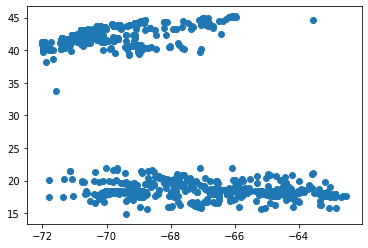

In [81]:
all_vals = [i for i in zones_compressed_dict.values()]
lat = [i[3] for i in sum(x,[])]
lon = [i[2] for i in sum(x,[])]
plt.scatter(lon,lat)
#plt.axis([-73,-65,15,22])

[-70, -69, 18, 18.5]

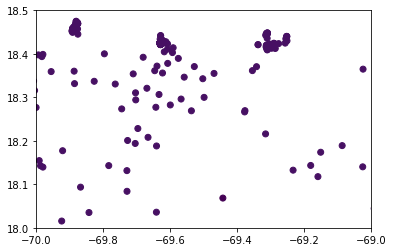

In [97]:
from sklearn.cluster import DBSCAN
Coords = np.array([[i,j] for i,j in zip(lon,lat)])
clustering = DBSCAN(eps=0.15, min_samples=2).fit(Coords)
plt.scatter(lon,lat,c=clustering.labels_)
plt.axis([-70,-69,18,18.5])